## Exploring Ireland's milk imports and exports

by YAP S S, 15 November 2017

A country's economy depends, sometimes heavily, on its exports and imports. 

The United Nations Comtrade database provides data on global trade. 

It will be used to analyse Ireland's imports and exports of milk and cream in 2015:

- How much does Ireland export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does Ireland import/export the most?
- Which are the regular customers, i.e. which countries buy milk from Ireland every month?
- Which countries does Ireland both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following :

- Type of Product: goods
- Frequency: monthly 
- Periods: January to May of 2015
- Reporter: Ireland
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)



## Accessing data through APIs

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in the following ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.
- `&r=372` is the ID code for Ireland https://comtrade.un.org/data/cache/reporterAreas.json

In [18]:
LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201505%2C201504%2C201503%2C201502%2C201501&r=372&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [19]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
#milk
milk.head() # to peek the first 5 row

Classification  Year  Period Period Desc.  Aggregate Level  Is Leaf Code  \
0             HS  2015  201504   April 2015                4             0   
1             HS  2015  201504   April 2015                4             0   
2             HS  2015  201504   April 2015                4             0   
3             HS  2015  201504   April 2015                4             0   
4             HS  2015  201504   April 2015                4             0   

   Trade Flow Code Trade Flow  Reporter Code Reporter  ...   Qty  \
0                2    Exports            372  Ireland  ...   NaN   
1                2    Exports            372  Ireland  ...   NaN   
2                1    Imports            372  Ireland  ...   NaN   
3                1    Imports            372  Ireland  ...   NaN   
4                1    Imports            372  Ireland  ...   NaN   

   Alt Qty Unit Code Alt Qty Unit  Alt Qty  Netweight (kg)  Gross weight (kg)  \
0                NaN          NaN      NaN        11753663                NaN   
1                NaN          NaN      NaN             660                NaN   
2                NaN          NaN      NaN             300                NaN   
3                NaN          NaN      NaN             211                NaN   
4                NaN          NaN      NaN            1452                NaN   

   Trade Value (US$)  CIF Trade Value (US$)  FOB Trade Value (US$)  Flag  
0            5202050                    NaN                    NaN     0  
1               2012                    NaN                    NaN     0  
2                455                    NaN                    NaN     0  
3               2007                    NaN                    NaN     0  
4               3845                    NaN                    NaN     0  

[5 rows x 35 columns]

You may wish to store a local copy as a CSV file, for example:

In [20]:
milk.to_csv('ire_milk_2015_5months.csv', index=False) 
# Download the CSV file and open with Excel to view the data

The data only covers the first five months of 2015. 

Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. 

The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [21]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

Period    Partner Trade Flow Milk and cream  Trade Value (US$)
0  201504      World    Exports    unprocessed            5202050
1  201504  Australia    Exports    unprocessed               2012
2  201504    Belgium    Imports    unprocessed                455
3  201504     Brazil    Imports    unprocessed               2007
4  201504   Bulgaria    Imports    unprocessed               3845

The data contains the total imports and exports per month, under the 'World' partner. 

Those rows are removed to keep only the per-country data.

In [22]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

Period    Partner Trade Flow Milk and cream  Trade Value (US$)
1  201504  Australia    Exports    unprocessed               2012
2  201504    Belgium    Imports    unprocessed                455
3  201504     Brazil    Imports    unprocessed               2007
4  201504   Bulgaria    Imports    unprocessed               3845
5  201504      China    Exports    unprocessed             165933

## Total trade flow

To answer the first question, 

'how much does the Ireland export and import and is the balance positive (more exports than imports)?',


In [23]:
#the dataframe is split into two groups: exports from the UK and imports into the UK. 
#The  trade values within each group are summed up to get the total trading.

grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports     98581151
Imports    114955743
Name: Trade Value (US$), dtype: int64

The balance is negative as Imports more than Exports. 

## Main trade partners

To address the second question, 

'Which are the main trading partners, i.e. from/to which countries does Ireland import/export the most?'

In [24]:
#The dataframe is split by country instead, and then each group aggregated for the total trade value. 
#This is done separately for imports and exports. 
#The result is sorted in descending order so that the main partners are at the top.

imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('Ireland imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to Ireland are:')
totalImports = grouped[VALUE].aggregate(sum).sort(inplace=False,ascending=False)
totalImports.head()

Ireland imports from 26 countries.
The 5 biggest exporters to Ireland are:


Partner
United Kingdom    93153674
Germany           13434598
Denmark            4042255
Finland            2192551
Poland              484557
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

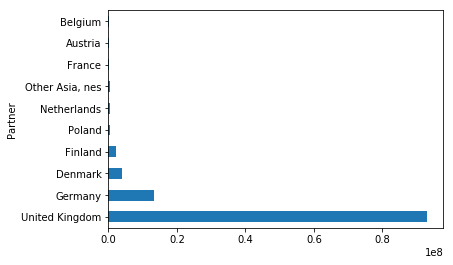

In [25]:
totalImports.head(10).plot(kind='barh');

In [26]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('Ireland exports to', len(grouped), 'countries.')
print('The 5 biggest importers from Ireland are:')
grouped[VALUE].aggregate(sum).order(ascending=False).head()

Ireland exports to 58 countries.
The 5 biggest importers from Ireland are:


Partner
United Kingdom    32662089
Nigeria            7920953
Netherlands        7497436
China              6909557
Algeria            3977362
Name: Trade Value (US$), dtype: int64

## Regular importers

Given that there are two commodities, the third question,

'Which are the regular customers, i.e. which countries buy milk from Ireland every month?', is meant in the sense that a regular customer imports both commodities every month. 



In [28]:

#This means that if the exports dataframe is grouped by country, each group has exactly 
#ten rows (two commodities bought each of the five months). 
#To see the countries, only the first month of one commodity has to be listed, 
#as by definition it's the same countries every month and for the other commodity.

def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201505) & (regular[COMMODITY] == 'processed')]

Period               Partner Trade Flow Milk and cream  Trade Value (US$)
269  201505                 China    Exports      processed            2220276
306  201505  United Arab Emirates    Exports      processed            1489134
309  201505        United Kingdom    Exports      processed            2568555

Just over 40% of the total Ireland exports are due to these regular customers.

In [29]:
regular[VALUE].sum() / exports[VALUE].sum() 

0.4298867944846779

## Bi-directional trade

To address the fourth question, 
'Which countries does Ireland both import from and export to?'

In [32]:
# a pivot table is used to list the total export and import value for each country. 

countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head() # check first 5 

Trade Flow    Exports   Imports
Partner                        
Algeria     3977362.0       NaN
Angola       907159.0       NaN
Areas, nes        NaN  135661.0
Australia      2012.0       NaN
Austria           NaN  152930.0

Removing the rows with a missing value denote by NaN will result in only those countries with bi-directional trade flow with Ireland.

In [31]:
countries.dropna()

Trade Flow         Exports     Imports
Partner                               
Belgium            59485.0    152569.0
Denmark            31023.0   4042255.0
France            911207.0    266726.0
Germany          2698523.0  13434598.0
Hungary            12272.0      4878.0
Italy            1358122.0     47224.0
Kenya             538950.0      3675.0
Netherlands      7497436.0    372644.0
Nigeria          7920953.0      1525.0
Poland            519955.0    484557.0
Saudi Arabia      747968.0        19.0
Singapore        1779331.0       170.0
South Africa      616224.0       191.0
Spain             939989.0      9708.0
United Kingdom  32662089.0  93153674.0

## Conclusions

The milk and cream trade of Ireland from January to May 2015 was analysed in terms of which countries Ireland mostly depends on for income (exports) and goods (imports). 

Over the period, Ireland had a trade deficit of over 15 million US dollars.

UK is the main partner, but it imported from the UK almost the triple in value than it exported to the UK. 

Ireland exported to over 58 countries during the period, but only imported from 5 countries, the main ones (top 5 by trade value) are China, UK, Netherland, Nigeria, Algeria. UK and Netherland being geographically close. 

Ireland has bi-directional trade (i.e. both exports and imports) with 15 countries. Singapore is the only country that geographically furthest away. 